In [1]:
import os 
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
import pandas as pd
import tifffile 
from tifffile.tifffile import imread
import cv2 as cv

In [2]:
#establish prefix for files
data_path = '/SNS/VENUS/IPTS-35945/shared/images_normalized/Gd Mask Normalization' 
assert os.path.exists(data_path)

In [3]:
#display file dimension and data type (determine whether file is Float 32 and needs to be converted to uint8 [single channel unsigned])
img = imread(data_path+'/normalized_sample_7998_obs_8015/integrated.tif')
img.shape
print (img.shape)
print (img.dtype)

(512, 512)
float32


In [4]:
#files from TimePix1 will be Float32, and will need to undergo conversion to uint8
gray = cv.bitwise_not(img)
cv.normalize(gray, gray, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)
gray_8bit =cv.convertScaleAbs(gray)

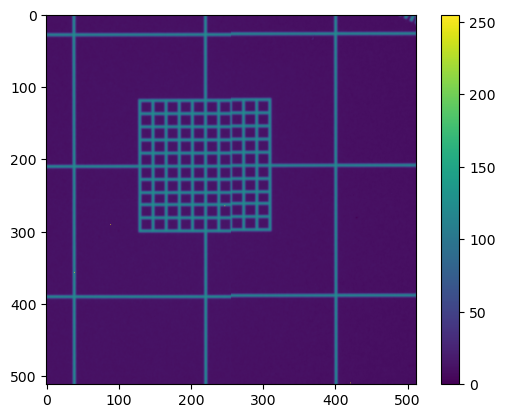

In [5]:
#establish source [src] file path, run through imread, plot
#gray_8bit = cv.imread(data_path+'/normalized_sample_7998_obs_8015/integrated.tif', cv.IMREAD_UNCHANGED)
plt.imshow(gray_8bit)
plt.colorbar()

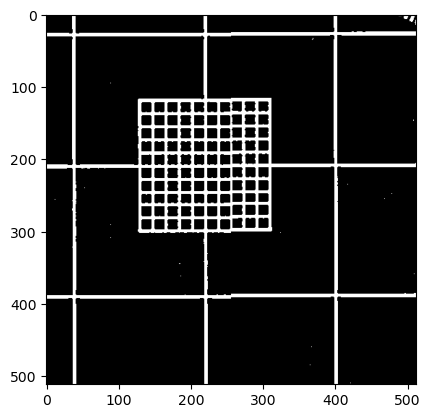

In [6]:
#Replots in true B/W -- notice introduction of artifacts
bw = cv.adaptiveThreshold(gray_8bit, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 15, -2)
plt.imshow(bw, cmap='gray')


In [7]:
#creates two separate images at highest contrast to separate horizontal and vertical features
horizontal = np.copy(bw)
vertical = np.copy(bw)

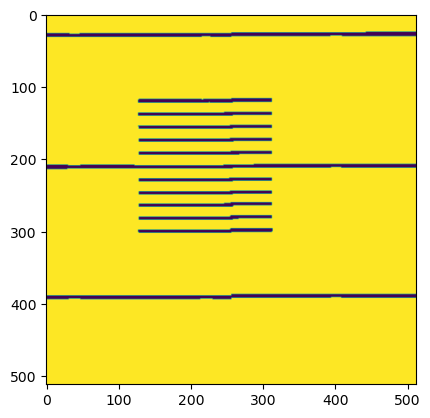

In [8]:
#horizontal processing -- separates and saves horizontal features
cols = horizontal.shape[1]
horizontal_size = cols // 30
horizontalStructure = cv.getStructuringElement(cv.MORPH_RECT, (horizontal_size,1))
horizontal = cv.erode(horizontal, horizontalStructure)
horizontal = cv.dilate(horizontal, horizontalStructure)
horizontal = cv.bitwise_not(horizontal)
H_edges = cv.adaptiveThreshold(horizontal, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 3, -2)
kernel = np.ones((2,2),np.uint8)
H_edges = cv.dilate(H_edges, kernel)
smooth = np.copy(horizontal)
smooth = cv.blur(smooth, (2,2))
(rows,cols) = np.where(H_edges != 0)
horizontal [rows,cols] = smooth[rows, cols]
plt.imshow(horizontal)

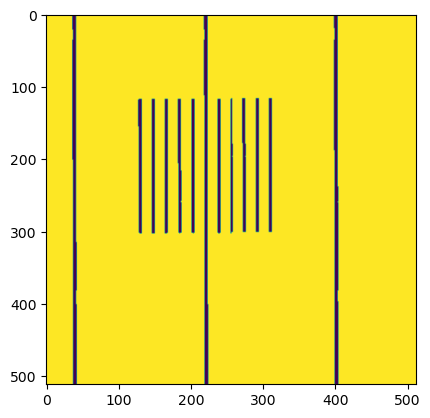

In [9]:
#vertical processing -- separates and saves vertical features
rows = vertical.shape[0]
verticalsize = rows // 30
verticalStructure = cv.getStructuringElement(cv.MORPH_RECT, (1,verticalsize))
#vertical processing -- *enhance!*
vertical = cv.erode(vertical, verticalStructure)
vertical = cv.dilate(vertical, verticalStructure)
vertical = cv.bitwise_not(vertical)
V_edges = cv.adaptiveThreshold(vertical, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 3, -2)
kernel = np.ones((2,2),np.uint8)
V_edges = cv.dilate(V_edges, kernel)
smooth = np.copy(vertical)
smooth = cv.blur(smooth, (2,2))
(rows,cols) = np.where(V_edges != 0)
vertical [rows,cols] = smooth[rows, cols]
plt.imshow(vertical)


(512, 512)
(512, 512)


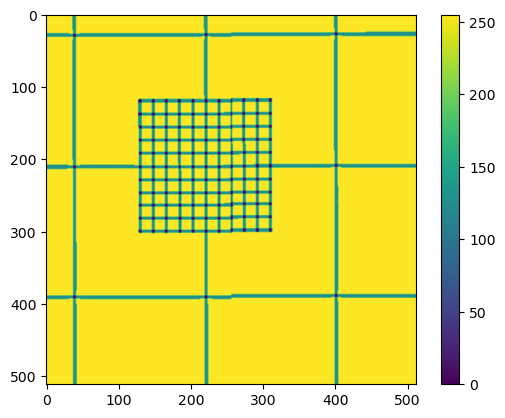

In [10]:
#Recombines the horizontal and vertical images into a single processed and edge-optimized image using 
#OpenCV "addWeighted" function
print (horizontal.shape)
print (vertical.shape)
alpha = .5
beta = 1-alpha
combined_image = cv.addWeighted(horizontal, alpha, vertical, beta, 0.0)
plt.imshow (combined_image)
plt.colorbar ()

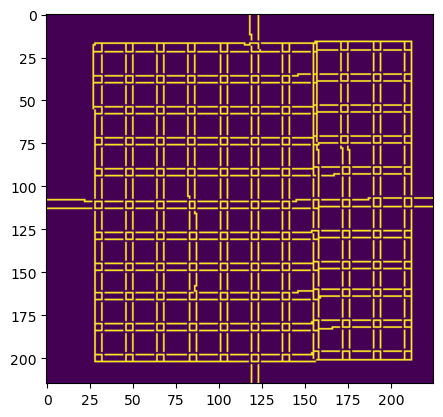

In [ ]:
#Defines the ROI and processes the image to detect and identify the edges
x,y,width,height =  100,100,225,215
roi=combined_image[y:y+height,x:x+width]
edges=cv.Canny(roi,0,150)
plt.imshow(edges)

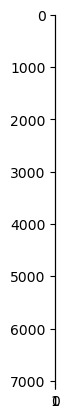

In [ ]:
#export the edge locations
edge_locations = np.column_stack(np.where(edges != 0))
edge_locations[:,0] += y
edge_locations[:,1] += x


